<a href="https://www.kaggle.com/code/cicinguyen/hyperparameter-tuning-for-clipping?scriptVersionId=141011996" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e21/sample_submission.csv


<div style="background-color: #f0f0f0; border: 3px solid #000; padding: 10px; text-align: center;">
    <h2 style="color: #000; font-size: 35px; font-family: Arial; font-weight: bold;">PS-S3-E21: Hyperparameter Tuning for Clipping</h2>
</div>

# Introduction 

*The objective is to optimize the performance of a RandomForestRegressor model using a creative blend of data exploration, feature engineering, and hyperparameter tuning.*

The unique challenge lies in the constraint of using a predefined model architecture while leveraging the power of our dataset to fine-tune its predictive capabilities. 

With a synthetic dataset at our disposal, we will embark on a meticulous process of identifying crucial features, defining clipping bounds, and refining our model's inputs to achieve better predictions. 

# Table of content

- [Section 1: Data Exploration](#section-1)
- [Section 2: Feature Importance](#section-2)
- [Section 3: Hyperparameter Tuning for Clipping](#section-3)
- [Section 4: Submission](#section-4)

# Libraries Used

In [2]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<a id="section-1"></a>
# Section 1: Data Exploration

## Load Data

In [3]:
df = pd.read_csv('/kaggle/input/playground-series-s3e21/sample_submission.csv')

df.head()

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,8.59,7.500,9.00,9.545,9.265,8.110,8.43,7.15,0.180,...,4.95,1.730,1.800,4.800,3.15,10.665,10.465,16.645,5.75,10.37
1,1,9.10,13.533,40.90,8.770,9.265,6.015,10.07,7.15,1.107,...,20.05,9.530,7.695,4.550,6.95,2.040,5.200,5.725,2.95,2.23
2,2,8.21,3.710,5.42,8.770,9.265,4.550,10.07,7.15,0.020,...,4.58,3.025,3.960,4.935,4.95,4.725,6.075,6.750,3.50,3.17
3,3,8.39,8.700,8.10,9.500,9.200,5.200,8.67,6.67,0.280,...,8.45,2.070,1.730,6.300,4.70,3.500,6.200,8.670,2.90,7.37
4,4,8.07,8.050,8.65,7.960,9.265,3.290,10.07,7.15,0.360,...,2.02,1.730,0.760,4.800,4.97,3.950,2.800,8.400,3.50,3.90


In [4]:
df.shape

(3500, 37)

In [5]:
df.describe()

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
count,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,...,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000
mean,1749.500000,8.473834,8.216993,9.291581,9.633064,8.065733,5.671581,9.461363,6.547433,0.340525,...,8.710466,3.002243,3.242654,4.816718,4.754389,4.285660,5.968980,7.837995,3.750349,4.068639
std,1010.507298,1.885712,3.040743,6.817822,1.439039,1.463881,2.721399,1.140365,1.663266,0.284751,...,6.438648,2.918355,2.713923,2.009161,1.547491,2.093388,2.576146,3.724861,1.682421,1.894632
min,0.000000,1.300000,0.000000,0.000000,4.900000,2.300000,0.200000,0.000000,0.000000,0.020000,...,0.044000,0.011000,0.000000,0.570000,0.089000,0.850000,2.025000,2.020000,0.364000,1.600000
25%,874.750000,7.470000,7.100000,7.300000,8.770000,6.830000,4.550000,8.980000,5.877500,0.214500,...,4.450000,1.140000,1.780000,3.520000,3.950000,2.290000,4.950000,5.725000,2.684000,2.900000
50%,1749.500000,8.280000,7.890000,8.300000,9.500000,7.980000,5.800000,9.430000,6.430000,0.247000,...,6.054000,1.730000,1.800000,4.600000,4.800000,3.950000,5.725000,7.500000,3.500000,3.700000
75%,2624.250000,9.110000,9.100000,8.700000,9.545000,9.265000,7.015000,10.070000,7.150000,0.370000,...,14.515000,3.025000,4.237500,5.000000,5.400000,4.725000,6.250000,8.400000,4.150000,4.450000
max,3499.000000,65.930000,46.950000,65.950000,16.900000,21.800000,59.400000,40.190000,15.900000,4.200000,...,35.000000,19.355000,27.025000,11.650000,10.700000,19.800000,55.400000,82.450000,19.375000,10.370000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 37 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      3500 non-null   int64  
 1   target  3500 non-null   float64
 2   O2_1    3500 non-null   float64
 3   O2_2    3500 non-null   float64
 4   O2_3    3500 non-null   float64
 5   O2_4    3500 non-null   float64
 6   O2_5    3500 non-null   float64
 7   O2_6    3500 non-null   float64
 8   O2_7    3500 non-null   float64
 9   NH4_1   3500 non-null   float64
 10  NH4_2   3500 non-null   float64
 11  NH4_3   3500 non-null   float64
 12  NH4_4   3500 non-null   float64
 13  NH4_5   3500 non-null   float64
 14  NH4_6   3500 non-null   float64
 15  NH4_7   3500 non-null   float64
 16  NO2_1   3500 non-null   float64
 17  NO2_2   3500 non-null   float64
 18  NO2_3   3500 non-null   float64
 19  NO2_4   3500 non-null   float64
 20  NO2_5   3500 non-null   float64
 21  NO2_6   3500 non-null   float64
 22  

## Distribution of Target

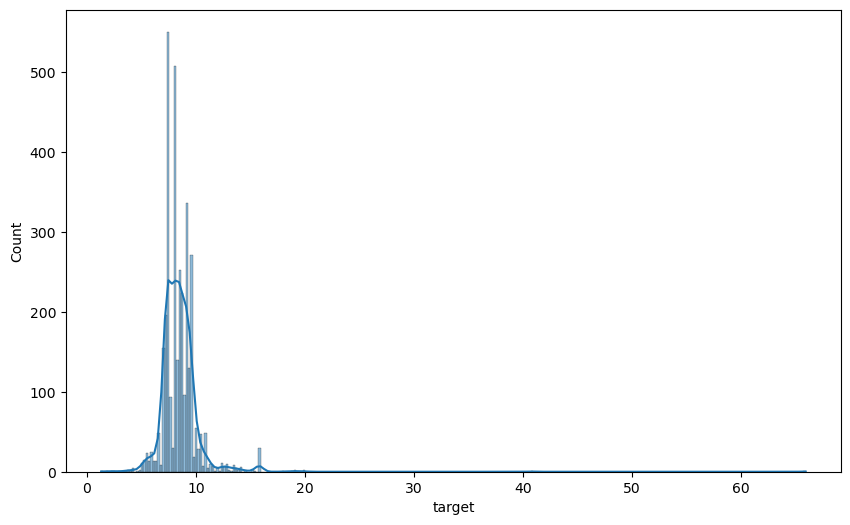

In [7]:
plt.figure(figsize=(10,6))
sns.histplot(df['target'], kde=True)
plt.show()

<a id="section-2"></a>
# Section 2: Feature Importance

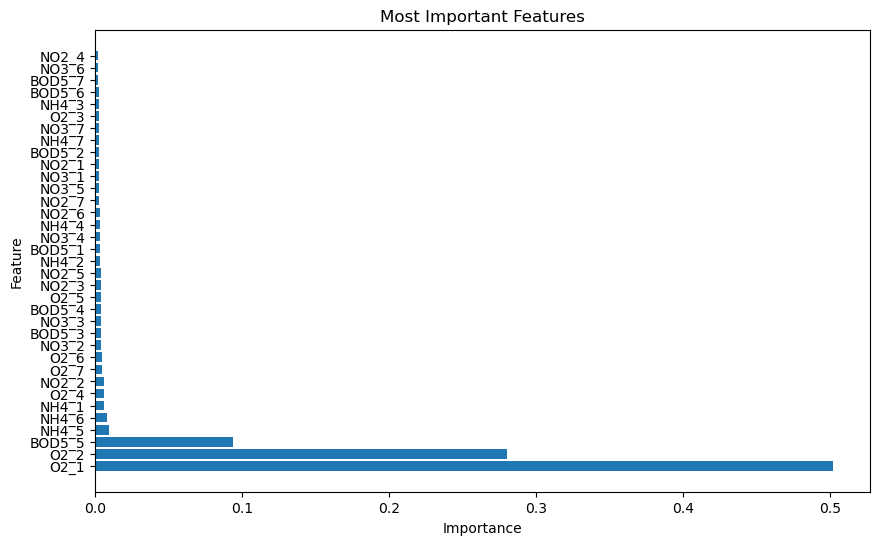

In [8]:
X = df.drop(['id', 'target'],axis=1)
y = df['target']

# Split data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, max_depth=7, n_jobs=-1, random_state=42)
rf_model.fit(X_train, y_train)

# Compute feature importances
feature_importances = rf_model.feature_importances_

importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Most Important Features')
plt.show()

* O2_1, O2_2, BOD5-5 are the most important 

<a id="section-3"></a>
# Section 3: Hyperparameter Tuning for Clipping

Clipping refers to the process of limiting the values of a variable to a specified range.
"hyperparameter tuning for clipping" means to finding the optimal lower and upper bounds for clipping the target variable. These bounds need to be chosen carefully to strike a balance between preserving the original distribution of the data and preventing unrealistic predictions.

By experimenting with different clipping bounds and evaluating the model's performance on a validation set, we can identify the range that leads to the best overall results. 

## Feature Removal based on Feature Importance

In [9]:
selected_features = ['O2_1', 'O2_2', 'BOD5_5']
new_train_data = df[selected_features].copy()

## Hyperparameter Tuning for Clipping

In [10]:
# Set up parameter ranges for grid search
param_grid = {
    'bot_bound': [6, 6.25, 6.5, 6.75, 7, 7.25],
    'top_bound': [32.5, 35, 37.5, 40],
    'n_cols': [3, 4, 5]
}

# Perform grid search with cross-validation
best_rmse = np.inf 
best_params = None

for bot_bound in param_grid['bot_bound']:
    for top_bound in param_grid['top_bound']:
        for col in param_grid['n_cols']:
            clipped_y = np.clip(y, bot_bound, top_bound)
            X_train, X_test, y_train, y_test = train_test_split(X, clipped_y, test_size=0.2, random_state=42)
            X_train_new = X_train[selected_features]
            
            #Train the model and calculate RMSE using cross-validation
            scores = cross_val_score(rf_model, X_train_new, y_train, scoring='neg_mean_squared_error', cv=5)
            mean_rmse = np.sqrt(-np.mean(scores))
            
            # Check if this combination of hyperparameters improves RMSE
            if mean_rmse < best_rmse:
                best_rmse = mean_rmse
                best_params = {'bot_bound': bot_bound, 'top_bound': top_bound, 'n_cols': col}

# Get the best hyperparameters
best_bot_bound = best_params['bot_bound']
best_top_bound = best_params['top_bound']
best_number_cols = best_params['n_cols']

print(f"Best Hyperparameters: bot_cutoff={best_bot_bound}, top_cutoff={best_top_bound}, n_columns={best_number_cols}")
print(f"Best RMSE: {best_rmse}")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Best Hyperparameters: bot_cutoff=7.25, top_cutoff=32.5, n_columns=5
Best RMSE: 1.0805159302984397


<a id="section-4"></a>
# Section 4: Submission

In [11]:
min_bot_bound = 7.25
min_top_bound = 32.5
min_n_cols = 5
df = pd.read_csv('/kaggle/input/playground-series-s3e21/sample_submission.csv')

df['target'] = df['target'].clip(min_bot_bound, min_top_bound)
non_zero_col = list(selected_features)[:min_n_cols] + ['target']

#Set other features' values to 0
for feature in df.columns:
    if feature not in selected_features:
        df[feature] = 0
        

In [12]:
df.head()

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,0,7.500,9.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,16.645,0,0
1,0,0,13.533,40.90,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5.725,0,0
2,0,0,3.710,5.42,0,0,0,0,0,0,...,0,0,0,0,0,0,0,6.750,0,0
3,0,0,8.700,8.10,0,0,0,0,0,0,...,0,0,0,0,0,0,0,8.670,0,0
4,0,0,8.050,8.65,0,0,0,0,0,0,...,0,0,0,0,0,0,0,8.400,0,0


In [13]:
df.to_csv('my_submission.csv', index=False)